# Heart Disease dataset classification and interpretability
Elena Markoska

This is a notebook containing the full experimentation along with explanations, on the dataset processed.cleveland.data obtained from [UCI machine learning datasets](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/). A summary of the most interesting points of this experimental notebook are distilled within the 2-page report submitted together with this notebook.

The Heart Disease ICU [kaggle competition](https://www.kaggle.com/ronitf/heart-disease-uci/kernels) further has numerous experiments on a similar dataset. However this dataset is different from the one provided by UCI. Many of the data points are changed, the properties of the data are different, and overall the conclusions found in the Kaggle competition do not apply to whatever experiments we perform on the original UCI dataset. Still, the competition served as inspiration for interesting exploratory analysis.

The outline of the notebook is as follows:

<ul>
    <li>Data exploration and preprocessing</li>
    <li>Classification model and optimisation of hyperparameters</li>
    <li>Summary and Outlook</li>
</ul>

## Data exploration and preprocessing

In [164]:
#Python 3

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import tree
import itertools
import seaborn as sns

import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

import shap 

#If you're unable to import any of the above libraries, you're welcome to use the following two lines

#import sys
#!{sys.executable} -m pip install name_of_library

In [3]:
dataset = pd.read_csv("C:/Users/elena/PycharmProjects/KerasPlayground/Data/processed.cleveland.data")
dataset.shape

(302, 14)

In [4]:
dataset.head()

,63.0,1.0,1.0.1,145.0,233.0,1.0.2,2.0,150.0,0.0,2.3,3.0,0.0.1,6.0,0
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


As we can see, the dataset does not contain column names. However, the description of the dataset conveniently provides explanations as to what the fourteen columns represent. We're first going to reload the dataset and assign column names. The original names of the columns aren't overly intuitive (e.g. oldpeak, slope, exang), so here we're going to rename them to strings that make a little more sense intuitively.

In [5]:
colnames=['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol',
          'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate',
          'exercise_induced_angina', 'st_depression', 'st_slope',
          'num_major_vessels', 'thalassemia', 'num']

dataset = pd.read_csv("C:/Users/elena/PycharmProjects/KerasPlayground/Data/processed.cleveland.data", 
            names=colnames, header=None)
dataset.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


The dataset contains ordinal values, however the dataset description provides explanations regarding what these ordinal values represent. Let's assign descriptive values to the ordinal values so the dataset makes a little more sense.

In [6]:
dataset.loc[dataset['sex'] == 0, 'sex'] = 'female'
dataset.loc[dataset['sex'] == 1, 'sex'] = 'male'

dataset.loc[dataset['chest_pain_type'] == 1, 'chest_pain_type'] = 'typical angina'
dataset.loc[dataset['chest_pain_type'] == 2, 'chest_pain_type'] = 'atypical angina'
dataset.loc[dataset['chest_pain_type'] == 3, 'chest_pain_type'] = 'non-anginal pain'
dataset.loc[dataset['chest_pain_type'] == 4, 'chest_pain_type'] = 'asymptomatic'

dataset.loc[dataset['fasting_blood_sugar'] == 0, 'fasting_blood_sugar'] = 'lower than 120mg/ml'
dataset.loc[dataset['fasting_blood_sugar'] == 1, 'fasting_blood_sugar'] = 'greater than 120mg/ml'

dataset.loc[dataset['rest_ecg'] == 0, 'rest_ecg'] = 'normal'
dataset.loc[dataset['rest_ecg'] == 1, 'rest_ecg'] = 'ST-T wave abnormality'
dataset.loc[dataset['rest_ecg'] == 2, 'rest_ecg'] = 'left ventricular hypertrophy'

dataset.loc[dataset['exercise_induced_angina'] == 0, 'exercise_induced_angina'] = 'no'
dataset.loc[dataset['exercise_induced_angina'] == 1, 'exercise_induced_angina'] = 'yes'

dataset.loc[dataset['thalassemia'] == '3.0', 'thalassemia'] = 'normal'
dataset.loc[dataset['thalassemia'] == '6.0', 'thalassemia'] = 'fixed defect'
dataset.loc[dataset['thalassemia'] == '7.0', 'thalassemia'] = 'reversable defect'

dataset.loc[dataset['st_slope'] == 1, 'st_slope'] = 'upsloping'
dataset.loc[dataset['st_slope'] == 2, 'st_slope'] = 'flat'
dataset.loc[dataset['st_slope'] == 3, 'st_slope'] = 'downsloping'

In [81]:
dataset.head(10)

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,num
0,63.0,male,typical angina,145.0,233.0,greater than 120mg/ml,left ventricular hypertrophy,150.0,no,2.3,downsloping,0.0,fixed defect,0
1,67.0,male,asymptomatic,160.0,286.0,lower than 120mg/ml,left ventricular hypertrophy,108.0,yes,1.5,flat,3.0,normal,2
2,67.0,male,asymptomatic,120.0,229.0,lower than 120mg/ml,left ventricular hypertrophy,129.0,yes,2.6,flat,2.0,reversable defect,1
3,37.0,male,non-anginal pain,130.0,250.0,lower than 120mg/ml,normal,187.0,no,3.5,downsloping,0.0,normal,0
4,41.0,female,atypical angina,130.0,204.0,lower than 120mg/ml,left ventricular hypertrophy,172.0,no,1.4,upsloping,0.0,normal,0
5,56.0,male,atypical angina,120.0,236.0,lower than 120mg/ml,normal,178.0,no,0.8,upsloping,0.0,normal,0
6,62.0,female,asymptomatic,140.0,268.0,lower than 120mg/ml,left ventricular hypertrophy,160.0,no,3.6,downsloping,2.0,normal,3
7,57.0,female,asymptomatic,120.0,354.0,lower than 120mg/ml,normal,163.0,yes,0.6,upsloping,0.0,normal,0
8,63.0,male,asymptomatic,130.0,254.0,lower than 120mg/ml,left ventricular hypertrophy,147.0,no,1.4,flat,1.0,reversable defect,2
9,53.0,male,asymptomatic,140.0,203.0,greater than 120mg/ml,left ventricular hypertrophy,155.0,yes,3.1,downsloping,0.0,reversable defect,1


Let's check if any values are NaN.

In [82]:
dataset.isnull().sum()

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
cholesterol                0
fasting_blood_sugar        0
rest_ecg                   0
max_heart_rate             0
exercise_induced_angina    0
st_depression              0
st_slope                   0
num_major_vessels          0
thalassemia                0
num                        0
dtype: int64

There doesn't seem to be any NaN values, however manual exploration through the data file reveals that there are some values showing ?. For example:

In [7]:
dataset.loc[dataset['thalassemia'] == '?']

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,num
87,53.0,female,non-anginal pain,128.0,216.0,lower than 120mg/ml,left ventricular hypertrophy,115.0,no,0.0,upsloping,0.0,?,0
266,52.0,male,asymptomatic,128.0,204.0,greater than 120mg/ml,normal,156.0,yes,1.0,flat,0.0,?,2


Let's try to find all columns which contain such a ? missing value.

In [8]:
for i in dataset.columns:
    newdataset = dataset.loc[lambda dataset: dataset[i] == '?']
    if(not newdataset.empty):
        print(i)

num_major_vessels
thalassemia


C:\Users\elena\PycharmProjects\NLP_Lab01\venv\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


There are several ways to approach this issue. For example, if the values were continuous, we could try to find the mean of all values and replace all missing values with this one. Another approach is to remove those rows entirely. A third approach is to replace the missing value with the most frequently used value in that specific column. As the dataset is rather small as it is, we'd prefer to not remove any rows, and instead we'll opt for the third approach.

Seeing as num_major_vessels and thalassemia are the only columns where missing values appear, let's count the number of appearances of all their values.

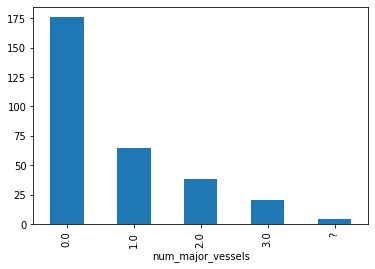

In [85]:
dataset.groupby('num_major_vessels').size().plot(kind='bar')

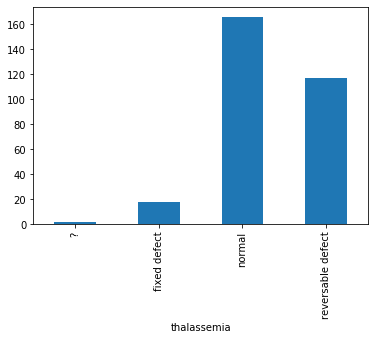

In [86]:
dataset.groupby('thalassemia').size().plot(kind='bar')

Based on this, we will replace the missing data in the num_major_vessels column with 0, and 3 for thalassemia.

In [9]:
dataset.loc[dataset['thalassemia'] == '?', 'thalassemia'] = 'normal'
dataset.loc[dataset['num_major_vessels'] == '?', 'num_major_vessels'] = '0.0'

In [88]:
dataset.dtypes

age                        float64
sex                         object
chest_pain_type             object
resting_blood_pressure     float64
cholesterol                float64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate             float64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels           object
thalassemia                 object
num                          int64
dtype: object

Next, we have 13 features (columns) which are contributing towards the final diagnosis. But what if any of them are correlated between each other? If they are strongly correlated, then we could theoretically remove one of them and maintain the same pattern and properties of the data without keeping the two. This is also known as dimensionality reduction. To examine this, we're going to construct a heatmap using the seaborn library. As the heatmap shows, however, there doesn't seem to be a strong correlation between any of the features. Lighter colours imply stronger correlation. As no features are correlated between each other, we can conclude that all 13 features are necessary, and we will not remove any of them.

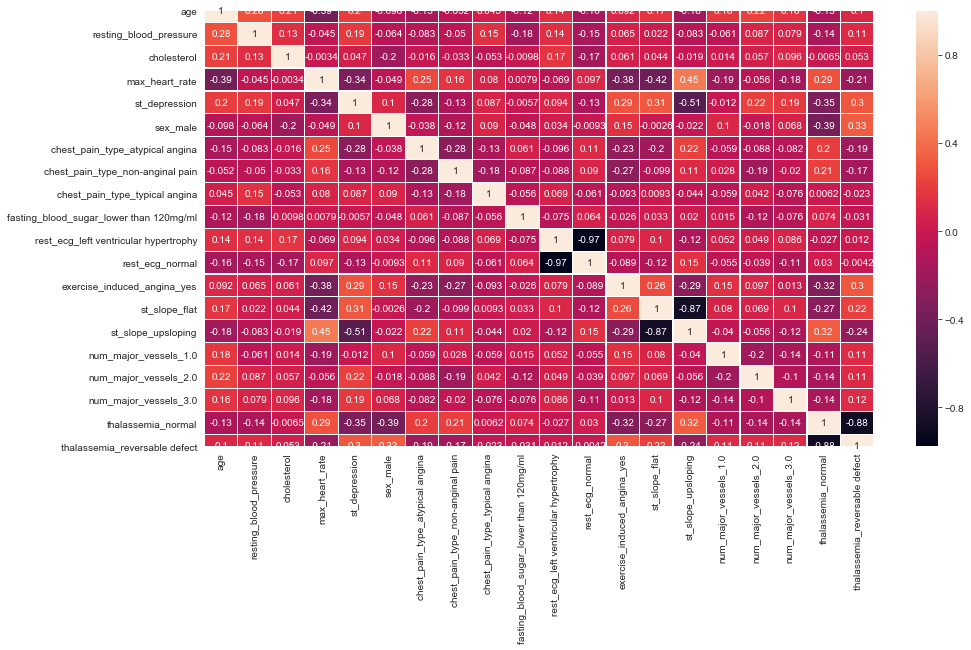

In [77]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,8))
sns.heatmap(dataset.corr(), annot = True, linewidths=.2)
plt.show()

As we're unable to perform our analysis on firmly categorical data, we're going to create dummy variables.

In [10]:
dataset = pd.get_dummies(dataset, drop_first=True)
dataset.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,num,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,...,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,num_major_vessels_1.0,num_major_vessels_2.0,num_major_vessels_3.0,thalassemia_normal,thalassemia_reversable defect
0,63.0,145.0,233.0,150.0,2.3,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,67.0,160.0,286.0,108.0,1.5,2,1,0,0,0,...,1,0,1,1,0,0,0,1,1,0
2,67.0,120.0,229.0,129.0,2.6,1,1,0,0,0,...,1,0,1,1,0,0,1,0,0,1
3,37.0,130.0,250.0,187.0,3.5,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,41.0,130.0,204.0,172.0,1.4,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


As a final step before we build our classification model, we're going to modify the final 'num' column signifying our diagnosis. The dataset description mentions that experiments concentrate on distinguishing between presence of heart disease (1,2,3,4) and no heart disease (0).

In [11]:
dataset.loc[:, "num"] = dataset.loc[:, "num"].apply(lambda x: 1 if x >= 1 else 0)
dataset.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate,st_depression,num,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,...,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,num_major_vessels_1.0,num_major_vessels_2.0,num_major_vessels_3.0,thalassemia_normal,thalassemia_reversable defect
0,63.0,145.0,233.0,150.0,2.3,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,67.0,160.0,286.0,108.0,1.5,1,1,0,0,0,...,1,0,1,1,0,0,0,1,1,0
2,67.0,120.0,229.0,129.0,2.6,1,1,0,0,0,...,1,0,1,1,0,0,1,0,0,1
3,37.0,130.0,250.0,187.0,3.5,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,41.0,130.0,204.0,172.0,1.4,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


## Classification model and optimisation of hyperparameters

First, we're going to split the dataset into a training set and a test set. We've implemented a separate function for calculating classification metrix and we're going to call it several times using different classifiers, namely Random Forest, Naive Bayes, and a Support Vector Machine. We're opting against a deep learning approach this time as we consider the dataset to be too small. Still, it's possible to implement a deep learning approach and it's subject for future experimentation.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('num', 1), 
                                    dataset['num'], test_size = .2, random_state=10)

In [13]:
def calculate_classification_metrics(test_targets, predictions) -> dict:
    results = {
        'accuracy': accuracy_score(test_targets, predictions),
        'f1-micro': f1_score(test_targets, predictions, average="micro"),
        'f1-macro': f1_score(test_targets, predictions, average="weighted"),
        'precision': precision_score(test_targets, predictions, average="weighted"),
        'recall': recall_score(test_targets, predictions, average="weighted"),
    }
    # 'accuracy', 'f1-micro', 'f1-macro', 'precision', 'recall'
    print(f"\tAccuracy score: {results['accuracy']:.3f}")
    print(f"\tF1-micro: {results['f1-micro']:.3f}")
    print(f"\tF1-macro: {results['f1-macro']:.3f}")
    print(f"\tPrecision score: {results['precision']:.3f}")
    print(f"\tRecall score: {results['recall']:.3f}")

    #return results

In [163]:
np.random.seed(86123) #To ensure reproducibility

forest = RandomForestClassifier(random_state = np.random.seed(86123))
forest.fit(X_train, y_train)
rf_predict = forest.predict(X_test)
print("Random Forest")
calculate_classification_metrics(rf_predict, y_test)

nb_classifier= MultinomialNB()
nb_classifier = nb_classifier.fit(X_train, y_train)
predictions_nb = nb_classifier.predict(X_test)
print("Naive Bayes")
calculate_classification_metrics(predictions_nb, y_test)

svm = SGDClassifier()
svm = svm.fit(X_train, y_train)
predictions_svm = svm.predict(X_test)
print("Support Vector Machine")
calculate_classification_metrics(predictions_svm, y_test)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


Random Forest
	Accuracy score: 0.738
	F1-micro: 0.738
	F1-macro: 0.741
	Precision score: 0.758
	Recall score: 0.738
Naive Bayes
	Accuracy score: 0.754
	F1-micro: 0.754
	F1-macro: 0.754
	Precision score: 0.755
	Recall score: 0.754
Support Vector Machine
	Accuracy score: 0.590
	F1-micro: 0.590
	F1-macro: 0.662
	Precision score: 0.880
	Recall score: 0.590


Some initial experimentation with Random Forest, Naive Bayes, and SVM reveal that Random Forest gives us reasonably good scores. However, scores of around 72% have still further room for improvement. Typically such improvement happens either by collecting more ground-truth data, we could do some feature engineering, or we could attempt some hyperparameter tuning. From now and further, we're going to focus on the hyperparameter tuning of our Random Forest classifier. 

When we instantiated our classifier object, we did not set any hyperparameters other than random_state, and that was only to ensure reproducibility of the code. Sklearn implements a set of default values, however it's difficult to foresee which value would be ideal for the problem before attempting them. It is also difficult to discover which hyperparameters specifically will have the highest impact on the metrics of the model, so we're going to have to come up with some trade-offs.

The sklearn documentation shows around 20 hyperparameters for this classifier. The idea is to use an approach which will help us search through the possible hyperparameters spaces and select the ones that yield the highest accuracy. Afterwards, once we have narrowed down the space of possible hyperparameters, we're going to search systematically through firmly given values for the hyperparameters in the previously selected interval. Naturally, the goal is also not to try and find hyperparameters which will fit the data so perfectly that it will become useless on unseen data points (overfitting), but instead to try and find the right hyperparameters while still maintain the generalising power. We're thus going to use cross validation during this grid search, which does not on its own prevent overfitting, however it does give us a very good idea about the model's performance on unseen data.

The code for the following experimentation and grid_searching has been heavily inspired by this [Medium post](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [15]:
forest = RandomForestClassifier()
print(forest.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


We're going to try and tune the following hyperparameters. We have chosen these as they seem relevant for the construction of the decision tree, however theis list is not exhaustive. A complete analysis would search through all 20 hyperparameters mentioned earlier. However, these searches take a considerable amount of time. Thus, here for illustrative optimisation we use:

<ul>
    <li> n_estimators (number of decision trees) </li>
    <li> max_features (max number of features considered for splitting a node)</li>
    <li> max_depth (max number of levels in each tree)</li>
    <li> bootstrap (whether or not we replace sampled data points)</li>
</ul>

In [16]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'bootstrap': [True, False]}


In [17]:
labels = dataset['num']
del dataset['num']

In [18]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
forest_random.fit(dataset, labels)
print("Best scores:")
print(forest_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished
C:\Users\elena\PycharmProjects\NLP_Lab01\venv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best scores:
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


In [158]:
baseline = RandomForestClassifier(random_state = np.random.seed(86123))
baseline.fit(X_train, y_train)
baseline_predict = baseline.predict(X_test)
print("Random Forest")
calculate_classification_metrics(baseline_predict, y_test)

forest_best = forest_random.best_estimator_
forest_best.fit(X_train,y_train)
forest_best_predict = forest_best.predict(X_test)
print("Best Random Forest")
calculate_classification_metrics(forest_best_predict, y_test)


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


Random Forest
	Accuracy score: 0.738
	F1-micro: 0.738
	F1-macro: 0.741
	Precision score: 0.758
	Recall score: 0.738
Best Random Forest
	Accuracy score: 0.770
	F1-micro: 0.770
	F1-macro: 0.772
	Precision score: 0.780
	Recall score: 0.770


We achieved a considerable improvement. Let's see if we can increase the scores a little higher. With RandomSearchCV we were able to narrow down the intervals for the specified hyperparameters. Using GridSearchCV will help us search through the values we provide.

In [20]:
param_grid = {
    'n_estimators':[50,100,150,200,250],
    'max_features':['sqrt'],
    'max_depth':[10,20,30],
    'bootstrap':[True],
}

forest = RandomForestClassifier()
grid_search = GridSearchCV(estimator = forest, param_grid = param_grid, cv=3, n_jobs = -1)
grid_search.fit(dataset, labels)

print(grid_search.best_params_)

C:\Users\elena\PycharmProjects\NLP_Lab01\venv\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


In [159]:
forest_best_grid = forest_random.best_estimator_
forest_best_grid.fit(X_train,y_train)
forest_best_grid_predict = forest_best_grid.predict(X_test)
print("Best Random Forest after grid search")
calculate_classification_metrics(forest_best_grid_predict, y_test)

Best Random Forest after grid search
	Accuracy score: 0.852
	F1-micro: 0.852
	F1-macro: 0.853
	Precision score: 0.853
	Recall score: 0.852


We achieved a rather good improvement. Overall, from the first value of our baseline 73% accuracy, we managed to increase it by 12%. We could also look  into the confusion matrix of the classifier, as well as the ROC graph, to get a further understanding of the performance of the model.

In [130]:
confusion_matrix = confusion_matrix(y_test, forest_best_grid_predict)
confusion_matrix

array([[28,  3],
       [ 7, 23]], dtype=int64)

AUC score: 0.8349462365591398


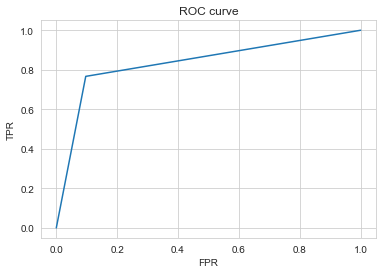

In [133]:
fpr, tpr, _ = roc_curve(y_test, forest_best_grid_predict)
print("AUC score: %s" % str(auc(fpr,tpr)))

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

Generally, a value between 0.8 and 0.9 for Area Under the Curve signifies the model is good. However, we could try to understand which of the features are most influential towards the final decision. After all, when a new patient arrives and we'd like to use our model to predict whether or not they have heart disease, we'd like to be able to explain <b>why</b> this is. This is where model explainability becomes very important.

First, we're going to employ a technique called permutation importance. For a given trained model, we're goiwg to try shuffling the values of every column and try to evaluate hos much they affect the predictions. If a random shuffle on a column doesn't affect the outcome, then it's likely that specific column doesn't play a large role in  the final diagnosis. Below, we've done this using the eli5 library. The code below is inspired by the [eli5 documentation](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html). As we created dummy variables, we can interpret the results as follows:

<ul>
    <li>In the cases where patients have number of major vessels being 1, this column most contributes to a diagnosis.</li>
    <li>Whether or not patients have non-anginal pain is also a strong factor in determining a diagnosis.</li>
    <li>Thalassemia causing defects is a strong contributing factor to heart disease.</li>
    <li>Another important factor is the maximum achieved heart rate.</li>
    <li>Age, left ventrivular hypertrophy, and atypical angina, help us the least in determining a diagnosis.</li>
</ul>

In [132]:
perm = PermutationImportance(forest_best_grid, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0557 ± 0.0334,num_major_vessels_1.0
0.0492 ± 0.0549,max_heart_rate
0.0393 ± 0.0262,thalassemia_reversable defect
0.0361 ± 0.0564,chest_pain_type_non-anginal pain
0.0361 ± 0.0382,cholesterol
0.0295 ± 0.0245,st_depression
0.0295 ± 0.0131,fasting_blood_sugar_lower than 120mg/ml
0.0295 ± 0.0435,st_slope_upsloping
0.0262 ± 0.0572,age
0.0230 ± 0.0262,num_major_vessels_3.0


Still, when a new patient comes to be admitted and we use our model to try and predict whether they're likely to have heart disease, we'd like to know why the model thinks so for that specific case. We're going to use a TreeExplainer from the shap library. The shap library is one of many approaches which increase model interpretability. Other libraries include Lime or InterpretML, or the previously used eli5.

In [72]:
explainer = shap.TreeExplainer(forest_best_grid)

Once we have the explainer, we're going to take a few patients and have a look at why the classifier decided their diagnosis for those specific cases.

In [73]:
patient = X_test.iloc[1,:].astype(float)
shap_values = explainer.shap_values(patient)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

The score of this specific patient is 0.78, rather close to 1, implying they have a high risk of having a heart disease. Factors that contribute towards how high the score is are the ST depression, their thalassemia (highest value), their max heart rate of 145. factors that help the patient are the fact that their chest pain type is a typical angina.

In [75]:
patient = X_test.iloc[7,:].astype(float)
shap_values = explainer.shap_values(patient)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], patient)


Our second patient has a rather low score, implying their diagnosis is going to be negative - no heart disease. Contributing factors that help the patient are the fact that thalassemia is normal, that they are female. Factors which contribute a little towards increasing the score are their maximum heart rate being 115.

## Summary and outlook

In this notebook, we experimented with a heart disease dataset. We tried several classifiers and chose to work with a Random Forest classifier. The initial dataset contains values from 0-4 regarding the final diagnosis, however we followed the example of the dataset information, stating that experiments with this specific dataset have been concentrated on distinguishing between disease (values 1-4) and no diesase (value 0). Preprocessing of the data further involved dealing with missing data, a correlation analysis to evaluate whether any of the columns are strongly correlated to each other (so we could potentially reduce the dimensionality), and creating dummy variables.

The initial Random Forest classifier was further examiened and a grid search was performed (first randomly, and then with targeted values), in order to discover the optimal hyperparameters. A considerable improvement was achieved on all major metrics.

To focus on model explainability, we used two techniques. The first one focuses on permutation importance, using which we were able to discover which features and their values contributed most towards the making of a diagnosis. Next, we used shap values to look at individual instances of patients to understand why for their specific case, a certain diagnosis was made.

It is expected that further improvement of all performance metrics will be achieved with the increase of the size of the dataset. 300 patients is a rather low number of patients to train a model with significant robustness. It is because of the small size of the dataset that we chose not to use a deep learning approach as deep learning approaches tend to require more data to generalise fully. This does not imply that a deep learning approach is infeasible in this example. Further increase of the dataset is expected to improve all metrics as well as unlock new machine learning techniques for further exploration.